# Yelp Photo Classification Project
#### Based on 2016 Kaggle Competition: https://www.kaggle.com/c/yelp-restaurant-photo-classification
#### Author: Chase Renick

### Imports

In [40]:
import tensorflow
import keras

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFilter
%matplotlib inline

#### Reading in the labels

In [42]:
df = pd.read_csv('/home/chaserenick/Downloads/train.csv')
photo_to_biz = pd.read_csv('/home/chaserenick/Downloads/train_photo_to_biz_ids.csv')
test_photo_to_biz = pd.read_csv('/home/chaserenick/Downloads/test_photo_to_biz.csv')

#### Reading in Training & Test JPGS & Sorts Them

In [43]:
import os
actual_photos = []
for filename in os.listdir('/home/chaserenick/train_photos'):
    newval = (filename.replace(".jpg",""))
    actual_photos.append(int(newval))
    
test_photos = []
for filename in os.listdir('/home/chaserenick/test_photos'):
    newvals = (filename.replace(".jpg",""))
    test_photos.append(int(newvals))
    
actual_photos = sorted(actual_photos)
test_photos = sorted(test_photos)

#### Number of Photos in the Train & Test Files

In [44]:
len(actual_photos), len(test_photos)

(7458, 8303)

#### Total Number of Business ID's

In [45]:
len(df), len(photo_to_biz), len(test_photo_to_biz)

(2000, 234842, 1190225)

#### Examining Train Labels

In [46]:
df.head()

,business_id,labels
0,1000,1 2 3 4 5 6 7
1,1001,0 1 6 8
2,100,1 2 4 5 6 7
3,1006,1 2 4 5 6
4,1010,0 6 8


#### Exploring Class Imbalance

Training Set:


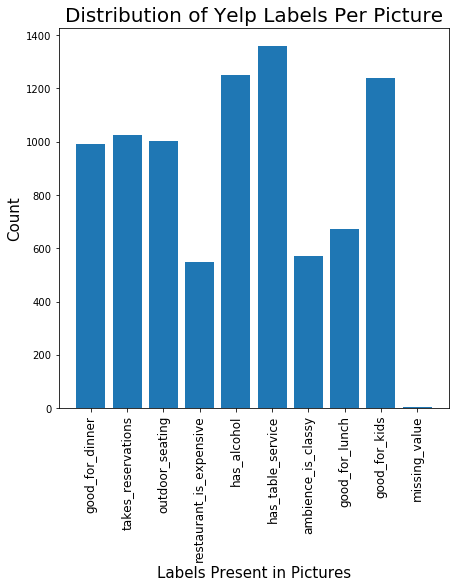

None


In [47]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

def class_imbalance(df):
    labels = df['labels']
    cnt = Counter ()

    label_dic = {}
    for val in labels:
        val = str(val)
        val = val.split()
        for num in val:
            if num == ' ':
                pass
            else:
                cnt[num] += 1

    # print (cnt)
    new = {'6': 'has_table_service', 
           '5': 'has_alcohol',
           '8': 'good_for_kids',
           '2': 'takes_reservations',
           '3': 'outdoor_seating',
           '1': 'good_for_dinner',
           '0': 'good_for_lunch',
           '7': 'ambience_is_classy',
           '4': 'restaurant_is_expensive',
           'nan': 'missing_value'}

    clarified = {new[k]: v for k, v in cnt.items()}

    plt.figure(figsize=(7,7))
    plt.title("Distribution of Yelp Labels Per Picture", fontsize=20)
    plt.bar(range(len(clarified)), clarified.values(), align='center')
    plt.xticks(range(len(clarified)), list(clarified.keys()), rotation=90, fontsize=12)
    plt.xlabel('Labels Present in Pictures', fontsize= 15)
    plt.ylabel("Count", fontsize=15)

    plt.show()
    
print ('Training Set:');
print (class_imbalance(df));

You will notice that there is class imbalance among the 8 categories.  We will address this later by applying weights to each class when building our model.

#### Exploring image Dimensions

In [48]:
from scipy.misc import imread
few = actual_photos[0:5]
for num in few:
    img = imread('/home/chaserenick/train_photos/' + str(num) + '.jpg')
    print ("SHAPE:", img.shape)
    print ("FLATTENED:",img.flatten())

SHAPE: (500, 375, 3)
FLATTENED: [164 122  84 ..., 113  61  22]
SHAPE: (500, 375, 3)
FLATTENED: [16  9  3 ..., 12 14 11]
SHAPE: (375, 500, 3)
FLATTENED: [ 31  20  18 ..., 164 176 172]
SHAPE: (332, 500, 3)
FLATTENED: [ 9  5  6 ..., 16  5 11]
SHAPE: (500, 375, 3)
FLATTENED: [186 146 134 ..., 122 117 123]


#### Take this random image from the Training Set

(500, 375, 3)


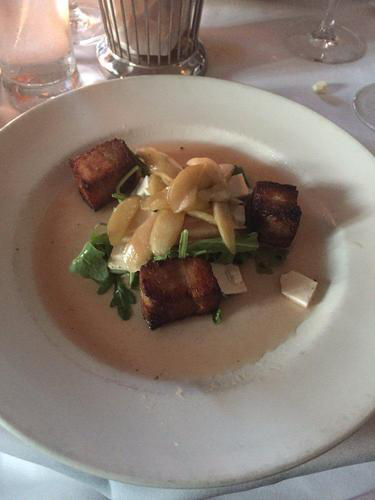

In [49]:
from keras.preprocessing.image import array_to_img
i = array_to_img(img)
print (img.shape)
i

#### Finding The Right Photos 

In [50]:
def get_photo_id_train(bus_id_num):
    
    """INPUT: Put the integer value of Business ID
    OUTPUT: A List of photo IDS associated with that business"""
    
    return (list(photo_to_biz.loc[photo_to_biz['business_id'] == bus_id_num]['photo_id']))

get_photo_id_train(7)

[252631,
 74568,
 79114,
 375176,
 198286,
 244314,
 430847,
 178578,
 419794,
 234870,
 127108,
 242916,
 432679,
 186745,
 308670,
 232768,
 94043,
 99848,
 85061,
 224938,
 64623]

The problem though is that not all of these picture ids are in the training set of photos Yelp provided us.  That sucks. So we have to find which ones are there and which ones are not, and make a new dataframe.

#### Finding actual images provided within the train and test photo id dataframes 

In [51]:
df_bus_pho_id = photo_to_biz[photo_to_biz['photo_id'].isin(actual_photos)]
df_test_pho_id = test_photo_to_biz[test_photo_to_biz['photo_id'].isin(test_photos)]

In [52]:
df_bus_pho_id = df_bus_pho_id.sort_values('photo_id')
reduced_test_pho_biz = df_test_pho_id.loc[~df_test_pho_id['photo_id'].duplicated()] # Gets Rid of Duplicates in Test Set
reduced_test_pho_biz = reduced_test_pho_biz.sort_values('photo_id')
reduced_test_pho_biz.head()

,photo_id,business_id
129083,1,3tv9h
455577,11,dicqg
692817,100,koxa6
230936,101,6q6fx
643345,105,jag3x


#### Adding JPG Columns to Test and Train Set to Verify Correct Business ID

In [53]:
df_bus_pho_id['jpg_num'] = actual_photos
reduced_test_pho_biz['jpg_num'] = test_photos

#### Verifying Dimensions for Training & Test Set

In [54]:
print (len(df_bus_pho_id),len(actual_photos))
print (len(reduced_test_pho_biz),len(test_photos))

7458 7458
8303 8303


### Train Dataframe with labels

In [55]:
df_bus_pho_id = df_bus_pho_id.sort_values('business_id')
uniq_bus = df_bus_pho_id.sort_values('business_id')
uniq_bus = list(uniq_bus.business_id.unique())
uniq_bus = df[df['business_id'].isin(uniq_bus)]
uniq_bus = uniq_bus.sort_values('business_id')
uniq_bus.head()

,business_id,labels
1539,3,0 8
1687,4,1 2 4 5 6
1752,5,1 2 4 5 6 7
1772,6,0 1 6 8
1904,8,1 2 4 5 6 7


####  Constructing a dataframe of unique businesses with pictures and their corresponding labels

In [56]:
new_df = []

for num in df_bus_pho_id['business_id']:
    if num in uniq_bus['business_id'].values:
        
        m = uniq_bus[uniq_bus['business_id']==num]
        new_df.append(m)
    else:
        pass
    
new_df = pd.concat(new_df)
new_df = new_df.sort_values('business_id')
new_df.head()

,business_id,labels
1539,3,0 8
1687,4,1 2 4 5 6
1687,4,1 2 4 5 6
1687,4,1 2 4 5 6
1687,4,1 2 4 5 6


#### Not the best join method but it works

In [57]:
df_bus_pho_id['labels'] = list(new_df['labels'][0:])
df_bus_pho_id.head()

,photo_id,business_id,jpg_num,labels
174629,105027,3,105027,0 8
20012,103565,4,103565,1 2 4 5 6
68303,107490,4,107490,1 2 4 5 6
62237,112016,4,112016,1 2 4 5 6
50634,111035,4,111035,1 2 4 5 6


In [58]:
one_hot = df_bus_pho_id
one_hot = one_hot.dropna()
a = one_hot['labels']
experiment = a[:]

#### Function for Creating Binary Labels from String Labels

In [59]:
def better_labels(labels):
    
    """INPUT: Take in a string of labels
    OUTPUT: Breaks them up so that each label is binary """

    has_table_service = []
    has_alcohol = []
    good_for_kids = []
    takes_reservations = []
    outdoor_seating = []
    good_for_dinner = []
    good_for_lunch = []
    ambience_is_classy = []
    restaurant_is_expensive = []

    for num in labels:
        vals = num.split()

        if '6' in vals:
            has_table_service.append(1)
        else:
            has_table_service.append(0)

        if '5' in vals:
            has_alcohol.append(1)
        else:
            has_alcohol.append(0)

        if '8' in vals:
            good_for_kids.append(1)
        else:
            good_for_kids.append(0)

        if '2' in vals:
            takes_reservations.append(1)
        else:
            takes_reservations.append(0)

        if '3' in vals:
            outdoor_seating.append(1)
        else:
            outdoor_seating.append(0)

        if '1' in vals:
            good_for_dinner.append(1)
        else:
            good_for_dinner.append(0)

        if '0' in vals:
            good_for_lunch.append(1)
        else:
            good_for_lunch.append(0)

        if '7' in vals:
            ambience_is_classy.append(1)
        else:
            ambience_is_classy.append(0)

        if '4' in vals:
            restaurant_is_expensive.append(1)
        else:
            restaurant_is_expensive.append(0)

        if 'nan' in vals:
            pass
        else:
            pass
        
    return has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy,restaurant_is_expensive

In [60]:
has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy,restaurant_is_expensive = better_labels(experiment)

del one_hot['labels'] # Removes column of string labels and replaces them with the following

one_hot['has_table_service'] = has_table_service
one_hot['has_alcohol'] = has_alcohol
one_hot['good_for_kids'] = good_for_kids
one_hot['takes_reservations'] = takes_reservations
one_hot['outdoor_seating'] = outdoor_seating
one_hot['good_for_dinner'] = good_for_dinner
one_hot['good_for_lunch'] = good_for_lunch
one_hot['ambience_is_classy'] = ambience_is_classy
one_hot['restaurant_is_expensive'] = restaurant_is_expensive

/home/chaserenick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/chaserenick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/chaserenick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

#### Cleaned Training Set with Binary Labels

In [61]:
sorted_one_hot = one_hot.sort_values('jpg_num')
sorted_one_hot.head()

,photo_id,business_id,jpg_num,has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy,restaurant_is_expensive
89379,10,242,10,1,1,1,1,0,0,1,0,0
34242,102,2611,102,1,1,0,1,0,1,0,1,1
168973,103,428,103,1,1,1,1,0,0,1,0,0
220509,104,3580,104,0,1,0,1,0,0,0,1,0
196072,109,2014,109,1,1,0,1,0,1,0,0,1


#### Cleaned Test Set with Binary Labels

In [66]:
reduced_test_pho_biz.head()

,photo_id,business_id,jpg_num,has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy
15,113977,003sg,113977,0,0,0,1,1,1,0,0
330,113183,00er5,113183,0,0,0,1,1,1,0,0
418,114583,00kad,114583,0,0,0,1,1,1,0,0
472,114684,00mc6,114684,0,0,0,1,1,1,0,0
514,10549,00v0t,10549,0,0,0,1,1,1,0,0


In [67]:
reduced_test_pho_biz.shape

(2881, 11)

#### Determining max and min for dimensions among all images

In [31]:
from scipy.misc import imread

train_batch = sorted_one_hot[:100]
test_batch = reduced_test_pho_biz[:100]

def train_dimensions(df):
    height_dic = Counter ()
    width_dic = Counter()
    
    for num in df['jpg_num']:
        img = imread('/home/chaserenick/train_photos/' + str(num) + '.jpg')
        img = imread('/home/chaserenick/test_photos/' + str(num) + '.jpg')
        height,width,depth = img.shape 
        height_dic[height] += 1
        width_dic[width] += 1
    
    return (height_dic),(width_dic)

train_height, train_width = train_dimensions(train_batch)
test_height, test_width = test_dimensions(test_batch)

### Examining Distributions in Train and Test

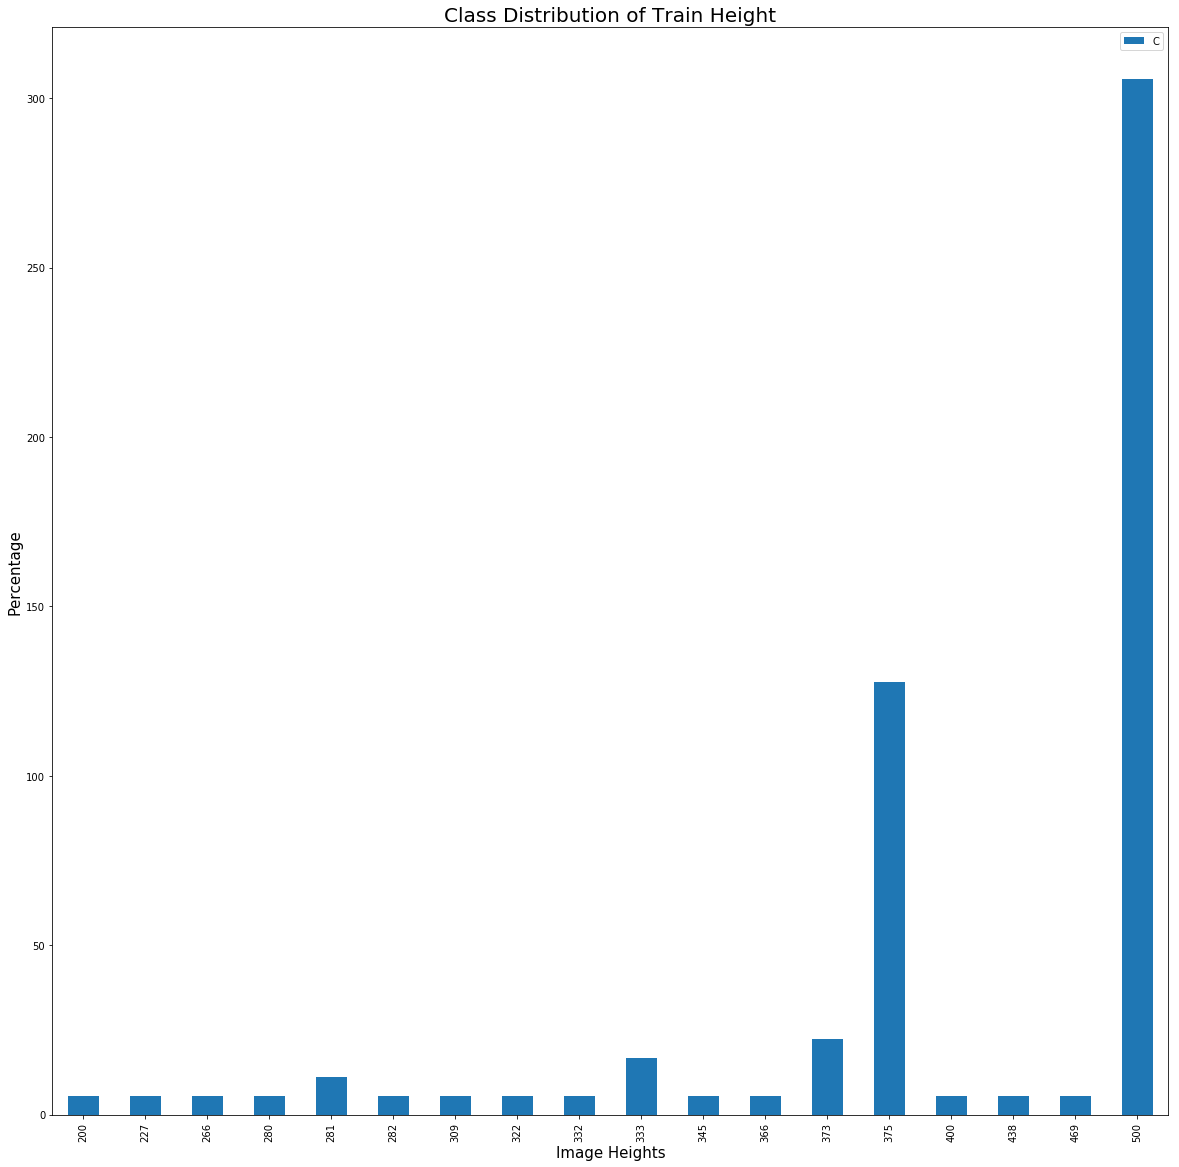

In [33]:
dic_tr_height = pd.Series(train_height)
dic_tr_height = ((dic_tr_height / len(dic_tr_height))*100)

dic_tr_height.plot(kind='bar', figsize=[20,20], legend=True)
plt.title("Class Distribution of Train Height", fontsize=20)
plt.xlabel('Image Heights', fontsize= 15)
plt.ylabel('Percentage', fontsize=15);
plt.legend('Count');

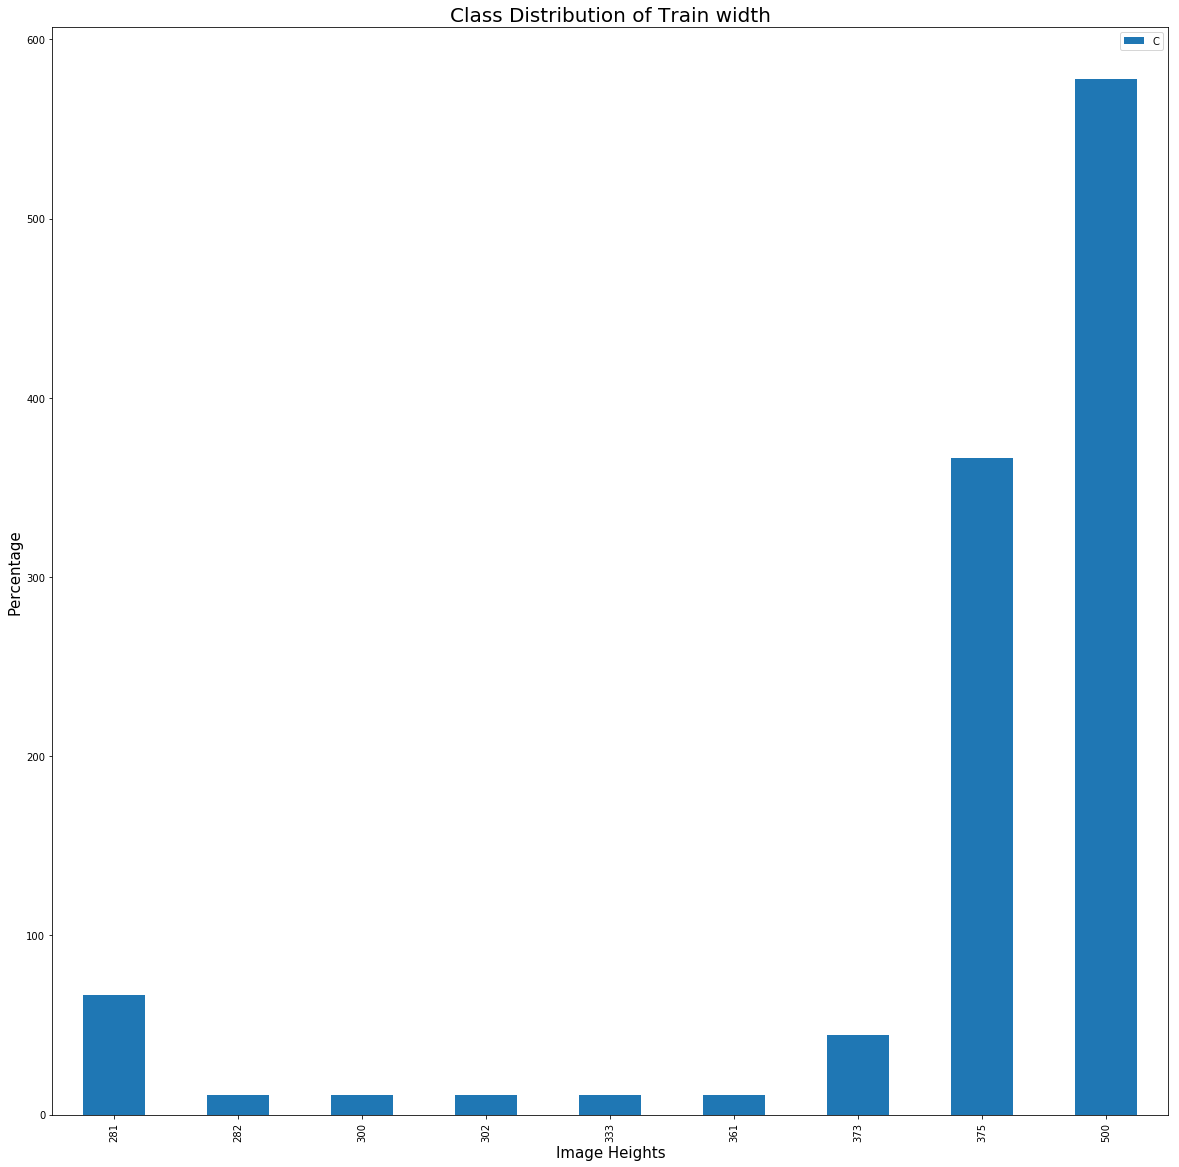

In [34]:
dic_tr_width = pd.Series(train_width)
dic_tr_width = ((dic_tr_width / len(dic_tr_width))*100)

dic_tr_width.plot(kind='bar', figsize=[20,20], legend=True)
plt.title("Class Distribution of Train width", fontsize=20)
plt.xlabel('Image Heights', fontsize= 15)
plt.ylabel('Percentage', fontsize=15);
plt.legend('Count');

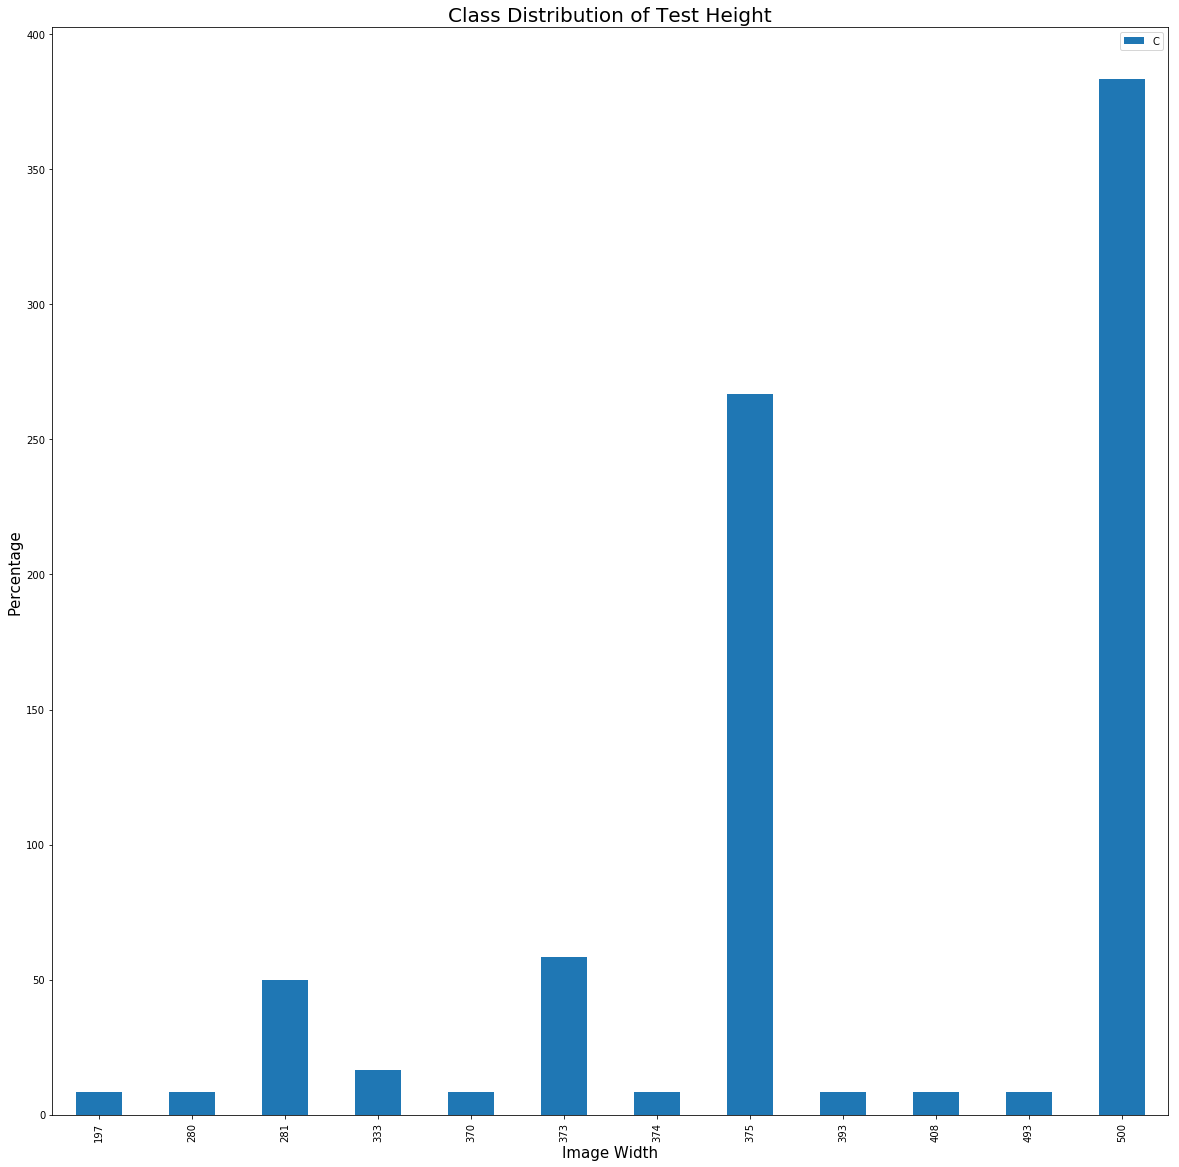

In [35]:
dic_tes_height = pd.Series(test_height)
dic_tes_height = ((dic_tes_height / len(dic_tes_height))*100)

dic_tes_height.plot(kind='bar', figsize=[20,20], legend=True)
plt.title("Class Distribution of Test Height", fontsize=20)
plt.xlabel('Image Width', fontsize= 15)
plt.ylabel('Percentage', fontsize=15);
plt.legend('Count');

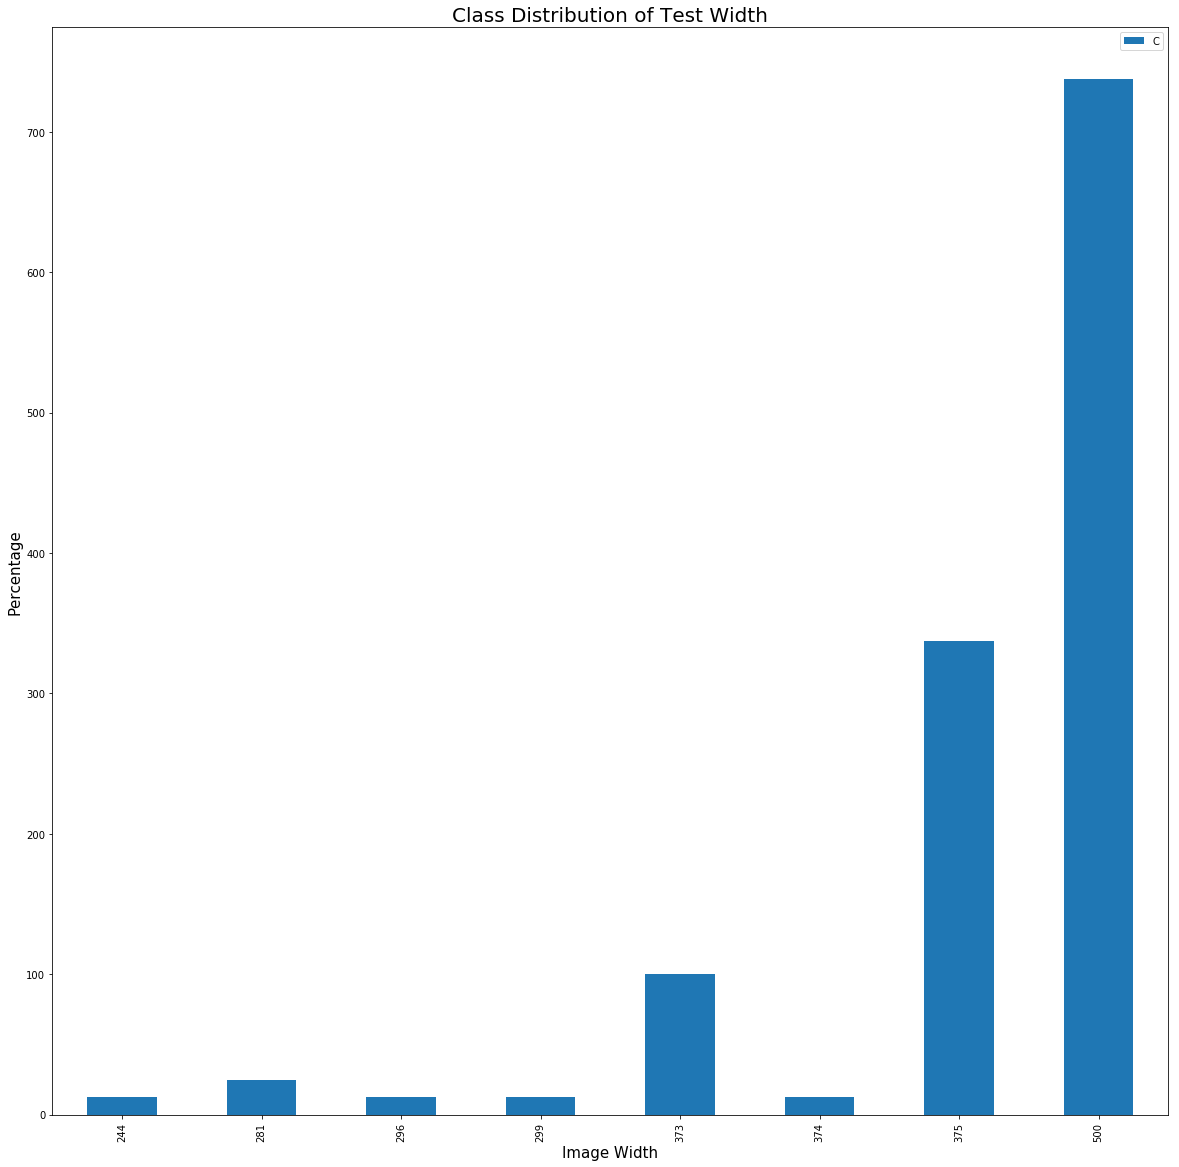

In [36]:
dic_tes_width = pd.Series(test_width)
dic_tes_width = ((dic_tes_width / len(dic_tes_width))*100)

dic_tes_width.plot(kind='bar', figsize=[20,20], legend=True)
plt.title("Class Distribution of Test Width", fontsize=20)
plt.xlabel('Image Width', fontsize= 15)
plt.ylabel('Percentage', fontsize=15);
plt.legend('Count');

### Preprocessing for a Convolutional NN

#### Training Set

In [37]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import time 

print("STARTED:", time.ctime())

cnn_resized_train = []
for num in sorted_one_hot[:7000]['jpg_num']:
    img = load_img('/home/chaserenick/train_photos/' + str(num) + '.jpg', target_size=(281,281))
    i = img_to_array(img)
    p = np.asarray(i)
    p = p / np.amax(p) 
    cnn_resized_train.append(p)

cnn_resized_train = np.asarray(cnn_resized_train)
cnn_resized_train = np.reshape(cnn_resized_train,(7000,281,281,3))
    
print ('FINISHED:',time.ctime())

STARTED: Sat Jul 22 17:49:09 2017
FINISHED: Sat Jul 22 17:49:44 2017


#### Test Set

In [38]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import time 

print("STARTED:", time.ctime())

cnn_resized_test = []
for num in reduced_test_pho_biz[:2881]['jpg_num']:
    img = load_img('/home/chaserenick/test_photos/' + str(num) + '.jpg', target_size=(281,281))
    i = img_to_array(img)
    p = np.asarray(i)
    p = p / np.amax(p) 
    cnn_resized_test.append(p)

cnn_resized_test = np.asarray(cnn_resized_test)
cnn_resized_test = np.reshape(cnn_resized_test,(2881,281,281,3))
    
print ('FINISHED:',time.ctime())

STARTED: Sat Jul 22 17:49:44 2017
FINISHED: Sat Jul 22 17:50:03 2017


### Preprocessing for a Single Dense Layer NN

#### Training Set

In [68]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
import numpy as np
import time 

print("STARTED:", time.ctime())

nn_resized_train = []
for num in sorted_one_hot[:7000]['jpg_num']:
    img = load_img('/home/chaserenick/train_photos/' + str(num) + '.jpg', target_size=(281,281))
    i = img_to_array(img)
    p = np.asarray(i)
    p = p.flatten()
    p = p / np.amax(p) 
    nn_resized_train.append(p)

nn_resized_train = np.asarray(nn_resized_train)
nn_resized_train = np.reshape(nn_resized_train,(7000,236883))
    
print ('FINISHED:',time.ctime())

STARTED: Sat Jul 22 18:19:30 2017
FINISHED: Sat Jul 22 18:20:09 2017


#### Test Set

In [69]:
from scipy.misc import imread
import scipy.misc
from keras.preprocessing.image import array_to_img, img_to_array

print("STARTED:", time.ctime())

nn_resized_test = []
for num in reduced_test_pho_biz[:2881]['jpg_num']:
    img = load_img('/home/chaserenick/test_photos/' + str(num) + '.jpg', target_size=(281,281))
    i = img_to_array(img)
    pt = np.asarray(i)
    pt = pt.flatten()
    pt = pt / np.amax(pt) 
    nn_resized_test.append(pt)

nn_resized_test = np.asarray(nn_resized_test)
nn_resized_test = np.reshape(nn_resized_test,(2881,236883))

print ('FINISHED:',time.ctime())

STARTED: Sat Jul 22 18:20:09 2017
FINISHED: Sat Jul 22 18:20:22 2017


##### Verify dimensions match

In [32]:
print (cnn_resized_train.shape)
print (cnn_resized_test.shape)

(7000, 281, 281, 3)
(2881, 281, 281, 3)


In [70]:
print (nn_resized_train.shape)
print (nn_resized_test.shape)

(7000, 236883)
(2881, 236883)


### New Labels: [takes_reservations, outdoor_seating, good_for_dinner]

In [71]:
multi_train_labels = np.asarray(sorted_one_hot[['has_table_service','has_alcohol','good_for_kids','takes_reservations','outdoor_seating','good_for_dinner','good_for_lunch','ambience_is_classy', 'restaurant_is_expensive']])

In [72]:
print ("Train_Labels:", '\n', multi_train_labels[:5])

Train_Labels: 
 [[1 1 1 1 0 0 1 0 0]
 [1 1 0 1 0 1 0 1 1]
 [1 1 1 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 0]
 [1 1 0 1 0 1 0 0 1]]


### Breaking up the Training Data into Training Set, Test Set, and Validation Set

In [73]:
from sklearn.model_selection import train_test_split

#### Baseline Data Split Based on Classes

In [134]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['has_table_service'][:7000]),
                                                                test_size=0.3)

In [77]:
X_train_ha, X_test_ha, y_train_ha, y_test_ha = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['has_alcohol'][:7000]),
                                                                test_size=0.3)

In [39]:
X_train_gfk, X_test_gfk, y_train_gfk, y_test_gfk = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['good_for_kids'][:7000]),
                                                                test_size=0.3)

In [41]:
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['takes_reservations'][:7000]),
                                                                test_size=0.3)

In [42]:
X_train_ods, X_test_ods, y_train_ods, y_test_ods = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['outdoor_seating'][:7000]),
                                                                test_size=0.3)

In [43]:
X_train_gfd, X_test_gfd, y_train_gfd, y_test_gfd = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['good_for_dinner'][:7000]),
                                                                test_size=0.3)

In [44]:
X_train_gfl, X_test_gfl, y_train_gfl, y_test_gfl = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['good_for_lunch'][:7000]),
                                                                test_size=0.3)

In [45]:
X_train_ac, X_test_ac, y_train_ac, y_test_ac = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['ambience_is_classy'][:7000]),
                                                                test_size=0.3)

In [126]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(nn_resized_train, 
                                                                np.array(sorted_one_hot['restaurant_is_expensive'][:7000]),
                                                                test_size=0.3)

#### NN Data Split

In [74]:
X1_train, X1_test, y1_train, y1_test = train_test_split(nn_resized_train, multi_train_labels[:7000], test_size=0.3)

#### CNN Data Split

In [36]:
X2_train, X2_test, y2_train, y2_test = train_test_split(cnn_resized_train, multi_train_labels[:7000], test_size=0.3)

### Baseline Model: KNN

##### Import Libraries

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import BaggingClassifier
from sklearn.cross_validation import cross_val_score

/home/chaserenick/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#####  KNN & Bagged KNN Prediction Functions: F1 Score

In [67]:
def knn(x_train, y_train, x_test, y_test):
    neigh = KNeighborsClassifier(n_neighbors=3).fit(x_train,y_train) 
    baseline_predicts = (neigh.predict(x_test))
    score= f1_score(baseline_predicts,y_test)
    return score

def knn_bagged(x_train, y_train, x_test, y_test):
    bagging_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(),
                           n_estimators=10).fit(x_train,y_train) 
    bagging_predicts = (bagging_knn.predict(x_test))
    score= f1_score(bagging_predicts,y_test)
    return score

##### KNN Prediction for Has Table Service

In [135]:
ts_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_ts[:500],y_train_ts[:500]) 
ts_predict = ts_fit.predict(X_test_ts[:500])
f1_score(ts_predict,y_test_ts[:500])

0.85131894484412463

##### KNN Prediction for Has Alcohol

In [83]:
ha_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_ha[:500],y_train_ha[:500]) 
ha_predict = ha_fit.predict(X_test_ts[:500])
f1_score(ha_predict,y_test_ts[:500])

0.73421052631578942

##### KNN Prediction for Good For Kids

In [40]:
gfk_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_gfk[:500],y_train_gfk[:500]) 
gfk_predict = gfk_fit.predict(X_test_gfk[:500])
f1_score(gfk_predict,y_test_gfk[:500])

0.54347826086956508

##### KNN Prediction for Takes Reservations

In [46]:
tr_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_tr[:500],y_train_tr[:500]) 
tr_predict = tr_fit.predict(X_test_tr[:500])
f1_score(tr_predict,y_test_tr[:500])

0.7518987341772152

##### KNN Prediction for Outdoor Seating

In [47]:
ods_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_ods[:500],y_train_ods[:500]) 
ods_predict = ods_fit.predict(X_test_ods[:500])
f1_score(ods_predict,y_test_ods[:500])

0.43842364532019706

##### KNN Prediction for Good for Dinner

In [48]:
gfd_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_gfd[:500],y_train_gfd[:500]) 
gfd_predict = gfd_fit.predict(X_test_gfd[:500])
f1_score(gfd_predict,y_test_gfd[:500])

0.68635724331926862

##### KNN Prediction for Good For Lunch

In [49]:
gfl_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_gfl[:500],y_train_gfl[:500]) 
gfl_predict = gfl_fit.predict(X_test_gfl[:500])
f1_score(gfl_predict,y_test_gfl[:500])

0.043478260869565223

##### KNN Prediction for Ambiance is Classy

In [50]:
ac_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_ac[:500],y_train_ac[:500]) 
ac_predict = ac_fit.predict(X_test_ac[:500])
f1_score(ac_predict,y_test_ac[:500])

0.49387755102040815

##### KNN Prediction for Restaurants is Classy

In [129]:
rs_fit = KNeighborsClassifier(n_neighbors=3).fit(X_train_rs[:500],y_train_rs[:500]) 
rs_predict = rs_fit.predict(X_test_rs[:500])
f1_score(rs_predict,y_test_rs[:500])

0.55535390199637025

### Weighting Classes To Resolve Class Imbalance Issue

In [81]:
sorted_one_hot.head()

,photo_id,business_id,jpg_num,has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy,restaurant_is_expensive
89379,10,242,10,1,1,1,1,0,0,1,0,0
34242,102,2611,102,1,1,0,1,0,1,0,1,1
168973,103,428,103,1,1,1,1,0,0,1,0,0
220509,104,3580,104,0,1,0,1,0,0,0,1,0
196072,109,2014,109,1,1,0,1,0,1,0,0,1


In [82]:
sorted_one_hot.shape

(7447, 12)

In [83]:
one = sum(sorted_one_hot['has_table_service'])
two = sum(sorted_one_hot['has_alcohol']) 
three = sum(sorted_one_hot['good_for_kids'])
four = sum(sorted_one_hot['takes_reservations']) 
five = sum(sorted_one_hot['outdoor_seating'])
six = sum(sorted_one_hot['good_for_dinner'])
seven = sum(sorted_one_hot['good_for_lunch']) 
eight = sum(sorted_one_hot['ambience_is_classy'])
nine = sum(sorted_one_hot['restaurant_is_expensive']) 

In [84]:
my_dic = {0:one, 1:two, 2: three, 3: four, 4: five, 5:six, 6:seven, 7:eight, 8:nine}
# my_dic = {'has_tb':one, 'has_al':two, 'gfk': three, 'tk': four, 'ods': five, 'gfd':six, 'gfl':seven, 'ac':eight, 'rs_ex':nine}

In [85]:
## Credit given to https://github.com/fchollet/keras/issues/5116

def get_weights(dictionary,smooth_factor):
    if smooth_factor > 0:
        p = max(my_dic.values()) * smooth_factor
        for k in my_dic.keys():
            my_dic[k] += p

    majority = max(my_dic.values())

    return {cls: float(majority / count) for cls, count in my_dic.items()}

In [86]:
class_weights = get_weights(my_dic,1)
class_weights

{0: 1.0,
 1: 1.0231229354521918,
 2: 1.2051740456409716,
 3: 1.0907014371371466,
 4: 1.226849373728723,
 5: 1.1340920336467095,
 6: 1.5436422413793103,
 7: 1.3386286648755987,
 8: 1.2889438758294904}

#### I wrote the following function for precision, recall, and  f1score for multilabeled output data in Keras:

In [87]:
def scores(y_pred,y_true):
    rows,columns = y_pred.shape
    correct_dims = rows*columns

    TP = []
    TN = []
    FP = []
    FN = []

    for i in range(rows):
        for j in range(columns):
            if y_pred[i][j] > .50 and y_true[i][j]==1:
                TP.append(1)
            elif y_pred[i][j] < .50 and y_true[i][j]==1:
                FN.append(1)
            elif y_pred[i][j] < .50 and y_true[i][j]==0:
                TN.append(1)
            elif y_pred[i][j] > .50 and y_true[i][j]==0:
                FP.append(1)
            else:
                pass
            
    if sum(TP)+sum(FN)+sum(TN)+sum(FP) != correct_dims:
        print ('Function is not totaling values correctly.  Fix before proceeding with further analysis.')
    else:
        precision = sum(TP) / (sum(TP)+sum(FP))
        recall = sum(TP) / (sum(TP)+sum(FN))
        fone_score = 2*((precision*recall) / (precision+recall))  
    
    return ('F1 Score:',fone_score,'Precision:',precision,'Recall:',recall)

### Neural Net Classification

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers 

model = Sequential()
model.add(Dense(units=1, activation='sigmoid', input_shape=[236883], kernel_regularizer= regularizers.l2(.001)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 236884    
Total params: 236,884
Trainable params: 236,884
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(nn_resized_train,np.array(sorted_one_hot['has_table_service'][:7000]), epochs=10, validation_split=.1)

Train on 6300 samples, validate on 700 samples
Epoch 1/10
6300/6300 [==============================] - 4s - loss: 3.6317 - acc: 0.7695 - val_loss: 3.8123 - val_acc: 0.7614
Epoch 2/10
6300/6300 [==============================] - 4s - loss: 3.6449 - acc: 0.7719 - val_loss: 3.8114 - val_acc: 0.7614
Epoch 3/10
6300/6300 [==============================] - 4s - loss: 3.6439 - acc: 0.7719 - val_loss: 3.8104 - val_acc: 0.7614
Epoch 4/10
6300/6300 [==============================] - 4s - loss: 3.6429 - acc: 0.7719 - val_loss: 3.8093 - val_acc: 0.7614
Epoch 5/10
6300/6300 [==============================] - 5s - loss: 3.6418 - acc: 0.7719 - val_loss: 3.8083 - val_acc: 0.7614
Epoch 6/10
6300/6300 [==============================] - 4s - loss: 3.6408 - acc: 0.7719 - val_loss: 3.8073 - val_acc: 0.7614
Epoch 7/10
6300/6300 [==============================] - 4s - loss: 3.6398 - acc: 0.7719 - val_loss: 3.8064 - val_acc: 0.7614
Epoch 8/10
6300/6300 [==============================] - 5s - loss: 3.6390 - ac

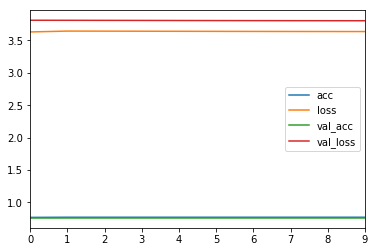

In [78]:
pd.DataFrame(history.history).plot();

In [79]:
model.predict(nn_resized_test)[0:10]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [90]:
f1_score(model.predict(nn_resized_test),(np.array(sorted_one_hot['has_table_service'][:2881])))

0.87218633783519273

### Multi-Label Experiment:

In [183]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers 

model = Sequential()
model.add(Dense(units=9, activation='sigmoid', input_shape=[236883], kernel_regularizer= regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 9)                 2131956   
Total params: 2,131,956
Trainable params: 2,131,956
Non-trainable params: 0
_________________________________________________________________


In [184]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [185]:
history = model.fit(X1_train,y1_train, validation_split=.01, epochs=10, class_weight=class_weights)

Train on 4851 samples, validate on 49 samples
Epoch 1/10
4851/4851 [==============================] - 8s - loss: 6.6437 - acc: 0.6104 - val_loss: 6.6589 - val_acc: 0.6009
Epoch 2/10
4851/4851 [==============================] - 8s - loss: 7.4745 - acc: 0.5713 - val_loss: 7.7802 - val_acc: 0.5397
Epoch 3/10
4851/4851 [==============================] - 8s - loss: 7.8897 - acc: 0.5367 - val_loss: 7.8665 - val_acc: 0.5442
Epoch 4/10
4851/4851 [==============================] - 8s - loss: 7.5364 - acc: 0.5666 - val_loss: 7.4135 - val_acc: 0.5692
Epoch 5/10
4851/4851 [==============================] - 8s - loss: 7.8192 - acc: 0.5604 - val_loss: 6.5144 - val_acc: 0.6395
Epoch 6/10
4851/4851 [==============================] - 8s - loss: 7.6617 - acc: 0.5637 - val_loss: 8.2581 - val_acc: 0.5125
Epoch 7/10
4851/4851 [==============================] - 8s - loss: 9.0721 - acc: 0.4754 - val_loss: 9.2702 - val_acc: 0.4467
Epoch 8/10
4851/4851 [==============================] - 8s - loss: 7.2318 - acc

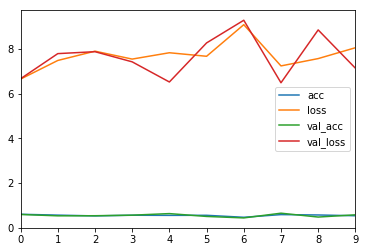

In [186]:
pd.DataFrame(history.history).plot();

In [188]:
p = model.predict(X1_test)

In [189]:
scores(p,y1_test)

('F1 Score:',
 0.5099199014171287,
 'Precision:',
 0.6568253968253969,
 'Recall:',
 0.41671701913393755)

In [80]:
model.evaluate(X1_test,y1_test)

2048/2100 [============================>.] - ETA: 0s

[8.0911888367789135, 0.51751323858896892]

### CNN: 1 Layer :

In [81]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.models import Sequential
from keras import regularizers 

model = Sequential()
model.add(Convolution2D(input_shape=(281,281,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='convolution2d'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=9, activation='sigmoid', input_shape=[636192], kernel_regularizer=regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution2d (Conv2D)       (None, 281, 281, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 141, 141, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 636192)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 5725737   
Total params: 5,726,633
Trainable params: 5,726,633
Non-trainable params: 0
_________________________________________________________________


In [82]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [83]:
history = model.fit(X2_train,y2_train, validation_split=.1, class_weight=class_weights)

Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 159s - loss: 3.7434 - acc: 0.6007 - val_loss: 0.6914 - val_acc: 0.6327
Epoch 2/10
4410/4410 [==============================] - 156s - loss: 0.6730 - acc: 0.6404 - val_loss: 0.6682 - val_acc: 0.6456
Epoch 3/10
4410/4410 [==============================] - 155s - loss: 0.6628 - acc: 0.6482 - val_loss: 0.6606 - val_acc: 0.6540
Epoch 4/10
4410/4410 [==============================] - 155s - loss: 0.6646 - acc: 0.6515 - val_loss: 0.6575 - val_acc: 0.6544
Epoch 5/10
4410/4410 [==============================] - 157s - loss: 0.6614 - acc: 0.6541 - val_loss: 0.6685 - val_acc: 0.6438
Epoch 6/10
4410/4410 [==============================] - 155s - loss: 0.6649 - acc: 0.6537 - val_loss: 0.6628 - val_acc: 0.6438
Epoch 7/10
4410/4410 [==============================] - 180s - loss: 0.6659 - acc: 0.6538 - val_loss: 0.6794 - val_acc: 0.6406
Epoch 8/10
4410/4410 [==============================] - 251s - l

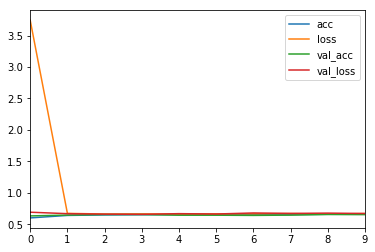

In [84]:
pd.DataFrame(history.history).plot();

In [89]:
p = model.predict(X2_test)

In [95]:
scores(p,y2_test)

('F1 Score:',
 0.6573527889889268,
 'Precision:',
 0.6835252340471323,
 'Recall:',
 0.6331107345758995)

In [86]:
model.evaluate(X2_test,y2_test)

2100/2100 [==============================] - 29s    


[0.6595032240095593, 0.64962963376726424]

### CNN: 2 Layers 

In [99]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.models import Sequential
from keras import regularizers 

model = Sequential()
model.add(Convolution2D(input_shape=(281,281,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='first_convolution1'))
model.add(MaxPooling2D(pool_size=(2,2),strides=1, padding='same'))
model.add(Convolution2D(input_shape=(281,281,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='second_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units=9, activation='sigmoid', input_shape=[636192], kernel_regularizer=regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_convolution1 (Conv2D)  (None, 281, 281, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 281, 281, 32)      0         
_________________________________________________________________
second_convolution (Conv2D)  (None, 281, 281, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 141, 141, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 636192)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 5725737   
Total params: 5,735,881
Trainable params: 5,735,881
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [101]:
history = model.fit(X2_train,y2_train, validation_split=.1, epochs=10, class_weight=class_weights)

Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 884s - loss: 0.9189 - acc: 0.6364 - val_loss: 0.6702 - val_acc: 0.6571
Epoch 2/10
4410/4410 [==============================] - 901s - loss: 0.6661 - acc: 0.6463 - val_loss: 0.6716 - val_acc: 0.6433
Epoch 3/10
4410/4410 [==============================] - 948s - loss: 0.6617 - acc: 0.6487 - val_loss: 0.6621 - val_acc: 0.6363
Epoch 4/10
4410/4410 [==============================] - 977s - loss: 0.6615 - acc: 0.6521 - val_loss: 0.6640 - val_acc: 0.6490
Epoch 5/10
4410/4410 [==============================] - 976s - loss: 0.6679 - acc: 0.6522 - val_loss: 0.6560 - val_acc: 0.6497
Epoch 6/10
4410/4410 [==============================] - 924s - loss: 0.6627 - acc: 0.6514 - val_loss: 0.6601 - val_acc: 0.6542
Epoch 7/10
4410/4410 [==============================] - 613s - loss: 0.6659 - acc: 0.6555 - val_loss: 0.6852 - val_acc: 0.6517
Epoch 8/10
4410/4410 [==============================] - 606s - l

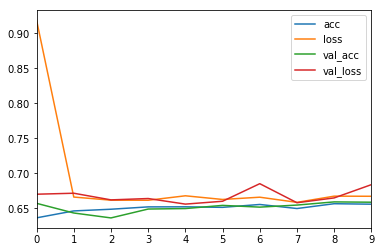

In [102]:
pd.DataFrame(history.history).plot();

In [103]:
p = model.predict(X2_test)

In [109]:
scores(p,y2_test)

('F1 Score:',
 0.6845221044590852,
 'Precision:',
 0.656922935947952,
 'Recall:',
 0.7145420113625037)

In [105]:
model.evaluate(X2_test,y2_test)

2100/2100 [==============================] - 75s    


[0.67540292217617948, 0.65037037259056452]

## Mock VGG Net: BEST MODEL 

In [110]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.models import Sequential
from keras import regularizers 

model = Sequential()
model.add(Convolution2D(input_shape=(281,281,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='first_convolution1'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(141,141,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='second_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(71,71,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='third_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(36,36,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='fourth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(18,18,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='fifth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(5,5,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='sixth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=9, activation='sigmoid', input_shape=[800], kernel_regularizer=regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_convolution1 (Conv2D)  (None, 281, 281, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 141, 141, 32)      0         
_________________________________________________________________
second_convolution (Conv2D)  (None, 141, 141, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 71, 71, 32)        0         
_________________________________________________________________
third_convolution (Conv2D)   (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
fourth_convolution (Conv2D)  (None, 36, 36, 32)        9248      
__________

In [111]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [112]:
history = model.fit(X2_train,y2_train, validation_split=.1, class_weight=class_weights)

Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 289s - loss: 0.7146 - acc: 0.6325 - val_loss: 0.6555 - val_acc: 0.6408
Epoch 2/10
4410/4410 [==============================] - 286s - loss: 0.6491 - acc: 0.6464 - val_loss: 0.6363 - val_acc: 0.6494
Epoch 3/10
4410/4410 [==============================] - 288s - loss: 0.6349 - acc: 0.6544 - val_loss: 0.6294 - val_acc: 0.6556
Epoch 4/10
4410/4410 [==============================] - 285s - loss: 0.6281 - acc: 0.6606 - val_loss: 0.6351 - val_acc: 0.6560
Epoch 5/10
4410/4410 [==============================] - 285s - loss: 0.6235 - acc: 0.6654 - val_loss: 0.6184 - val_acc: 0.6696
Epoch 6/10
4410/4410 [==============================] - 284s - loss: 0.6151 - acc: 0.6732 - val_loss: 0.6153 - val_acc: 0.6773
Epoch 7/10
4410/4410 [==============================] - 286s - loss: 0.6122 - acc: 0.6762 - val_loss: 0.6102 - val_acc: 0.6701
Epoch 8/10
4410/4410 [==============================] - 285s - l

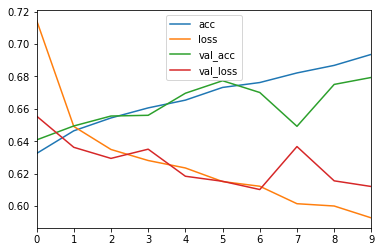

In [113]:
pd.DataFrame(history.history).plot();

In [114]:
p = model.predict(X2_test)

In [115]:
scores(p,y2_test)

('F1 Score:',
 0.691787342786992,
 'Precision:',
 0.6955864570737605,
 'Recall:',
 0.6880295026412838)

In [116]:
model.evaluate(X2_test,y2_test)

2100/2100 [==============================] - 35s    


[0.60740917864299959, 0.67455026717413036]

#### SAME MODEL as above but with more epochs.  
#### Result = although accuracy went up and loss went down it did not improve the f1score of our model.

In [117]:
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model
from keras.models import Sequential
from keras import regularizers 

model = Sequential()
model.add(Convolution2D(input_shape=(281,281,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='first_convolution1'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(141,141,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='second_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(71,71,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='third_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(36,36,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='fourth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(18,18,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='fifth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Convolution2D(input_shape=(5,5,3), filters=32, kernel_size=3, activation='relu', padding='same', data_format="channels_last", 
                      name='sixth_convolution'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=9, activation='sigmoid', input_shape=[800], kernel_regularizer=regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_convolution1 (Conv2D)  (None, 281, 281, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 141, 141, 32)      0         
_________________________________________________________________
second_convolution (Conv2D)  (None, 141, 141, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 71, 71, 32)        0         
_________________________________________________________________
third_convolution (Conv2D)   (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
fourth_convolution (Conv2D)  (None, 36, 36, 32)        9248      
__________

In [118]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [119]:
history = model.fit(X2_train,y2_train, validation_split=.1, epochs=20, class_weight=class_weights)

Train on 4410 samples, validate on 490 samples
Epoch 1/20
4410/4410 [==============================] - 280s - loss: 0.7054 - acc: 0.6371 - val_loss: 0.6510 - val_acc: 0.6481
Epoch 2/20
4410/4410 [==============================] - 279s - loss: 0.6416 - acc: 0.6517 - val_loss: 0.6382 - val_acc: 0.6494
Epoch 3/20
4410/4410 [==============================] - 280s - loss: 0.6314 - acc: 0.6581 - val_loss: 0.6298 - val_acc: 0.6642
Epoch 4/20
4410/4410 [==============================] - 279s - loss: 0.6246 - acc: 0.6641 - val_loss: 0.6253 - val_acc: 0.6748
Epoch 5/20
4410/4410 [==============================] - 281s - loss: 0.6187 - acc: 0.6701 - val_loss: 0.6190 - val_acc: 0.6689
Epoch 6/20
4410/4410 [==============================] - 281s - loss: 0.6112 - acc: 0.6775 - val_loss: 0.6136 - val_acc: 0.6769
Epoch 7/20
4410/4410 [==============================] - 280s - loss: 0.6015 - acc: 0.6864 - val_loss: 0.6070 - val_acc: 0.6814
Epoch 8/20
4410/4410 [==============================] - 281s - l

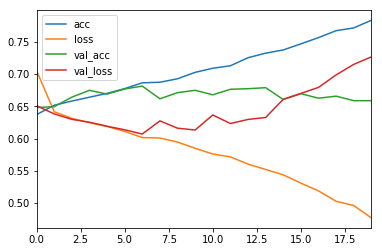

In [120]:
pd.DataFrame(history.history).plot();

In [121]:
p = model.predict(X2_test)

In [122]:
scores(p,y2_test)

('F1 Score:',
 0.6732741959462808,
 'Precision:',
 0.669524935935344,
 'Recall:',
 0.6770656832452906)

In [123]:
model.evaluate(X2_test,y2_test)

2100/2100 [==============================] - 36s    


[0.70106413977486748, 0.65116403080168228]

### VGG Net

In [44]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers 
from keras.optimizers import SGD

model = Sequential()
model.add(keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(281,281,3)))
model.add(Flatten())
model.add(Dense(units=9, activation='sigmoid', input_shape=[32768], kernel_regularizer=regularizers.l2(.01)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 294921    
Total params: 15,009,609
Trainable params: 15,009,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X2_train,y2_train, validation_split=.1, class_weight=class_weights)

Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 8905s - loss: 7.7934 - acc: 0.5380 - val_loss: 7.8202 - val_acc: 0.5381
Epoch 2/10
 160/4410 [>.............................] - ETA: 8299s - loss: 7.9343 - acc: 0.5306

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
p = model.predict(X2_test)

In [ ]:
scores(p,y2_test)

In [ ]:
model.evaluate(X2_test,y2_test)

### Model Comparison Dataframe

In [39]:
ex_comparison = pd.DataFrame([['KNN', '-', '.85','.73','.54','.75','.44','.68','.04','.49','.55'],
                              ['NN Single Class','-', '.87','.85','-','.78','.65','-','-','-','-' ], 
                              ['NN Multi-Class', '.51', '-','-','-','-','-','-','-','-','-'],
                              ['CNN Multi-Class (2Layers)', '.68', '-','-','-','-','-','-','-','-','-'],
                              ['CNN Multi-Class (Mock VGG)', '.69', '-','-','-','-','-','-','-','-','-'],
                              ['VGGNET16', 'Need more time to train', '-','-','-','-','-','-','-','-','-']])
ex_comparison.columns = ['Model Type','F1 Score', 'has_table_service', 'has_alcohol', 'good_for_kids', 'takes_reservations', 'outdoor_seating', 'good_for_dinner','good_for_lunch','ambience_is_classy','restaurant_is_expensive']
ex_comparison

,Model Type,F1 Score,has_table_service,has_alcohol,good_for_kids,takes_reservations,outdoor_seating,good_for_dinner,good_for_lunch,ambience_is_classy,restaurant_is_expensive
0,KNN,-,.85,.73,.54,.75,.44,.68,.04,.49,.55
1,NN Single Class,-,.87,.85,-,.78,.65,-,-,-,-
2,NN Multi-Class,.51,-,-,-,-,-,-,-,-,-
3,CNN Multi-Class (2Layers),.68,-,-,-,-,-,-,-,-,-
4,CNN Multi-Class (Mock VGG),.69,-,-,-,-,-,-,-,-,-
5,VGGNET16,Need more time to train,-,-,-,-,-,-,-,-,-


## Thanks for reading